# Copyright Netherlands eScience Center and Centrum Wiskunde & Informatica <br>
** Function     : Emotion recognition and forecast with ** <br>
** Author       : Yang Liu & Tianyi Zhang** <br>
** First Built  : 2020.05.17 ** <br>
** Last Update  : 2020.05.22 ** <br>
** Library      : Pytorth, Numpy, os, DLACs, matplotlib **<br>
Description     : This notebook serves to test the prediction skill of deep neural networks in emotion recognition and forecast. The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Many to one prediction.** <br>

Return Values   : Time series and figures <br>

**This project is a joint venture between NLeSC and CWI** <br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
import numbers

# for data loading
import os
# for pre-processing and machine learning
import numpy as np
#import sklearn
#import scipy
import torch
import torch.nn.functional

sys.path.append("C:\\Users\\nosta\\ConvLSTM_emotion\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.ConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
datapath = 'C:\\Users\\nosta\\ConvLSTM_emotion\\Data_CASE'
output_path = 'C:\\Users\\nosta\\ConvLSTM_emotion\\results'

In [3]:
if __name__=="__main__":
    print ('*********************** extract variables *************************')
    data = np.load(os.path.join(datapath, "data_10s.npz"))
    #data = np.load(os.path.join(datapath, "data_2s.npz"))
    #data = np.load(os.path.join(datapath, "data_0.5s.npz"))
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    sample = data["Samples"][:] # (batch_size, sample_size, channels)
    label_c = data["Labels_c"][:] # (batch_size, sample_size, 2)
    label = data["Labels"][:] # (batch_size, 2)
    subject = data["Subject_id"][:] # (batch_size, 2)
    video_label = data["Video_labels"][:] # (batch_size,1)

*********************** extract variables *************************


In [4]:
    #################################################################################
    #########                      pre-processing                           #########
    #################################################################################
    # choose the target dimension for reshaping of the signals
    batch_size, sample_size, channels = sample.shape
    _, _, label_channels = label_c.shape
    x_dim = 5
    y_dim = 5
    series_len = sample_size // (y_dim * x_dim)
    # reshape the input and labels
    #sample_xy = np.reshape(sample,[batch_size, series_len, y_dim, x_dim, channels], order='F')
    sample_xy = np.reshape(sample,[batch_size, series_len, y_dim, x_dim, channels])
    label_c_xy = np.reshape(label_c,[batch_size, series_len, y_dim, x_dim, label_channels])
    #################################################################################
    #########                       normalization                           #########
    #################################################################################
    print('================  extract individual variables  =================')
    sample_1 = sample_xy[:,:,:,:,0]
    sample_2 = sample_xy[:,:,:,:,1]
    sample_3 = sample_xy[:,:,:,:,2]
    sample_4 = sample_xy[:,:,:,:,3]
    sample_5 = sample_xy[:,:,:,:,4]
    
    label_c_valance = label_c_xy[:,:,:,:,0]
    label_c_arousal = label_c_xy[:,:,:,:,1]
    
    # using indicator for training
    # video_label_3D = np.repeat(video_label[:,np.newaxis,:],series_len,1)
    # video_label_4D = np.repeat(video_label_3D[:,:,np.newaxis,:],y_dim,2)
    # video_label_xy = np.repeat(video_label_4D[:,:,:,np.newaxis,:],x_dim,3)
    # video_label_xy.astype(float)
    print ('=========================   normalize data   ===========================')
    sample_1_norm = dlacs.preprocess.operator.normalize(sample_1)
    sample_2_norm = dlacs.preprocess.operator.normalize(sample_2)
    sample_3_norm = dlacs.preprocess.operator.normalize(sample_3)
    sample_4_norm = dlacs.preprocess.operator.normalize(sample_4)
    sample_5_norm = dlacs.preprocess.operator.normalize(sample_5)
    
    label_c_valance_norm = dlacs.preprocess.operator.normalize(label_c_valance)
    label_c_arousal_norm = dlacs.preprocess.operator.normalize(label_c_arousal)
    print('================  save the normalizing factor  =================')
    sample_1_max = np.amax(sample_1)
    sample_1_min = np.amin(sample_1)
    sample_2_max = np.amax(sample_2)
    sample_2_min = np.amin(sample_2)
    sample_3_max = np.amax(sample_3)
    sample_3_min = np.amin(sample_3)
    sample_4_max = np.amax(sample_4)
    sample_4_min = np.amin(sample_4)
    sample_5_max = np.amax(sample_5)
    sample_5_min = np.amin(sample_5)
    
    label_c_valance_max = np.amax(label_c_valance)
    label_c_valance_min = np.amin(label_c_valance)
    label_c_arousal_max = np.amax(label_c_arousal)
    label_c_arousal_min = np.amin(label_c_arousal)

================  extract individual variables  =================
=========================   normalize data   ===========================
================  save the normalizing factor  =================


In [5]:
    # first check of data shape
    print(sample.shape)
    print(label_c.shape)
    print(label.shape)
    print(subject.shape)
    print(video_label.shape)
    # check of reshape
    print(label_c_xy.shape)
    #print(sample[300,:100,1])
    print("=======================")
    #print(sample_xy[300,:4,:,:,1])

(3690, 1000, 8)
(3690, 1000, 2)
(3690, 2)
(3690, 1)
(3690, 1)
(3690, 40, 5, 5, 2)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [6]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 5
    #hidden_channels = [3, 3, 2] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    learning_rate = 0.01
    num_epochs = 100
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print ('*******************  cross validation and testing data  *********************')
    # take 10% years as testing data
    test_len = batch_size // 10 * 2
    # iterations
    iterations = batch_size - test_len

*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************


In [7]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = dlacs.ConvLSTM.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    model.load_state_dict(torch.load(os.path.join(output_path, 'convlstm_emotion_hl_1_kernel_3_lr_0.01_epoch_500_validSIC.pkl'),
                                     map_location=device))
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_emotion_hl_1_kernel_3_lr_0.01_epoch_500_validSIC.pkl'))
    print(model)
    # check the sequence length (dimension in need for post-processing)
    _, sequence_len, height, width = sample_1_norm.shape

*******************  load exsited LSTM model  *********************


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\nosta\\ConvLSTM_emotion\\results\\convlstm_emotion_hl_1_kernel_3_lr_0.01_epoch_500_validSIC.pkl'

In [7]:
    %%time
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    _, sequence_len, height, width = sample_1_norm.shape
    # initialize our model
    model = dlacs.ConvLSTM.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)

*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.


G:\Anaconda\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(5, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(5, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(5, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(5, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
Wall time: 7 s


In [19]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi.weight
tensor([[[[-0.0462,  0.0080, -0.0835],
          [ 0.1415,  0.1050, -0.0149],
          [-0.0819, -0.1153, -0.1139]],

         [[-0.1280,  0.0669,  0.0994],
          [ 0.0641, -0.0091, -0.1008],
          [ 0.0709,  0.0190, -0.1305]],

         [[ 0.1098,  0.0286, -0.0751],
          [ 0.1438,  0.0837,  0.1393],
          [-0.0610, -0.0658,  0.1107]],

         [[ 0.1442,  0.1400, -0.1337],
          [ 0.0109, -0.0077,  0.0062],
          [-0.1268,  0.0479, -0.0059]],

         [[-0.0267,  0.0680, -0.1253],
          [ 0.0656,  0.1415,  0.1333],
          [-0.1431, -0.0730,  0.0952]]],


        [[[ 0.0676,  0.0405, -0.1113],
          [-0.1024,  0.0473, -0.0706],
          [ 0.0761, -0.1360, -0.0666]],

         [[-0.0577, -0.1429, -0.0058],
          [ 0.0075, -0.1271, -0.1442],
          [-0.0007, -0.0369, -0.1170]],

         [[ 0.0250, -0.1097,  0.1011],
          [ 0.0515, -0.0578, -0.0964],
          [ 0.0106, -0.0379, -0.0005]],

         [[-0.1165,  0.0069, 

In [9]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  12
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])


In [8]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs * iterations)
    # loop of epoch
    for t in range(num_epochs):
        for i in range(iterations):
            # Clear stored gradient
            model.zero_grad()
            # loop of timestep
            for timestep in range(sequence_len):
                # hidden state re-initialized inside the model when timestep=0
                #################################################################################
                ########          create input tensor with multi-input dimension         ########
                #################################################################################
                # create variables
                x_input = np.stack((sample_1_norm[i,timestep,:,:],
                                    sample_2_norm[i,timestep,:,:],
                                    sample_3_norm[i,timestep,:,:],
                                    sample_4_norm[i,timestep,:,:],
                                    sample_5_norm[i,timestep,:,:])) #vstack,hstack,dstack
                x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
                #################################################################################
                ########       create training tensor with multi-input dimension         ########
                #################################################################################
                y_train_stack = np.stack((label_c_valance_norm[i,timestep,:,:],
                                          label_c_arousal_norm[i,timestep,:,:])) #vstack,hstack,dstack
                y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
                #################################################################################   
                # Forward pass
                y_pred, _ = model(x_var, timestep)
                # choose training data
                y_train = y_var        
                # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
                # Please Make Sure y_pred & y_train have the same dimension
                # accumulate loss
                if timestep == 0:
                    loss = loss_fn(y_pred, y_train)
                else:
                    loss += loss_fn(y_pred, y_train)
                #print (timestep)
            #print(y_pred.shape)
            #print(y_train.shape)
            # print loss at certain iteration
            if i % 1000 == 0:
                print("Epoch {} Iteration {} MSE: {:0.3f}".format(t, i, loss.item()))
                # Gradcheck requires double precision numbers to run
                #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
                #print(res)
            hist[i+t*iterations] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()
    
            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'convlstm_emotion.pkl'))
    # save the entire model
    #torch.save(model, os.path.join(output_path,'convlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 Iteration 0 MSE: 17.856


KeyboardInterrupt: 

*******************  Loss with time  **********************
*******************  Loss with time (log)  **********************


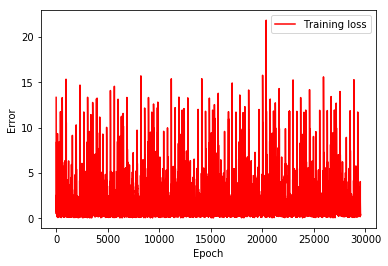

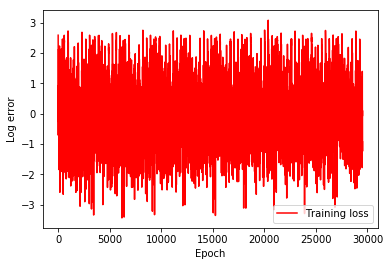

In [12]:
    #################################################################################
    ###########                 after training statistics                 ###########
    #################################################################################
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'ConvLSTM_train_error.png'),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log error')
    plt.legend()
    plt.show()
    fig01.savefig(os.path.join(output_path,'ConvLSTM_train_log_error.png'),dpi=150)

In [ ]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    
    # error score for temporal-spatial fields, without keeping spatial pattern
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        It calculates RMSE over the domain, not over time. The spatial structure
        will not be kept.
        Parameter
        ----------------------
        x: input time series with the shape [time, lat, lon]
        """
        x_series = x.reshape(x.shape[0],-1)
        y_series = y.reshape(y.shape[0],-1)
        rmse = np.sqrt(np.mean((x_series - y_series)**2,1))
        rmse_std = np.sqrt(np.std((x_series - y_series)**2,1))
    
        return rmse, rmse_std
    
    # error score for temporal-spatial fields, keeping spatial pattern
    def MAE(x,y):
        """
        Calculate the MAE. x is input series and y is reference series.
        It calculate MAE over time and keeps the spatial structure.
        """
        mae = np.mean(np.abs(x-y),0)
        
        return mae
    
    def MSE(x, y):
        """
        Calculate the MSE. x is input series and y is reference series.
        """
        

In [ ]:
    %%time
    #################################################################################
    ########                           prediction                            ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # forecast array
    pred_valance = np.zeros((test_len, series_len, y_dim, x_dim),dtype=float)
    pred_arousal = np.zeros((test_len, series_len, y_dim, x_dim),dtype=float)
    for n in range(test_len):
        # Clear stored gradient
        model.zero_grad()
        for timestep in range(sequence_len):
            x_input = np.stack((sample_1_norm[batch_size-test_len+n,sequence_len,:,:],
                                sample_2_norm[batch_size-test_len+n,sequence_len,:,:],
                                sample_3_norm[batch_size-test_len+n,sequence_len,:,:],
                                sample_4_norm[batch_size-test_len+n,sequence_len,:,:],
                                sample_5_norm[batch_size-test_len+n,sequence_len,:,:]))
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).to(device)
            # make prediction
            last_pred, _ = model(x_var_pred, timestep)
            # GPU data should be transferred to CPU
            pred_valance[n,timestep,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
            pred_arousal[n,timestep,:,:] = last_pred[0,1,:,:].cpu().data.numpy()
    
    # save prediction as npz file
    np.savez_compressed(os.path.koin(output_path,'ConvLSTM_emotion_pred.npz'),
                        valance=pred_valance, arousal=pred_arousal)

In [ ]:
    #####################################################################################
    ########         visualization of prediction and implement metrics           ########
    #####################################################################################
    # plot
    # compute mse
    